In [1]:
from cities.deployment.tracts_minneapolis.predict_new import TractsModelPredictor

from cities.utils.plot_ts import (plot_coefs, summarize_time_series,
                                  plot_model_summary)

from chirho.indexed.ops import IndexSet, gather, indices_of

from cities.utils.data_loader import db_connection
import time
import torch
import pyro


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
start = time.time()
with db_connection() as conn:
    predictor = TractsModelPredictor(conn)

end = time.time()
print("Time elapsed:", end - start)

Time elapsed: 4.111011505126953


In [3]:
predictor.train_model(override=True, num_steps=55)

[iteration 0001] loss: 17252.2148
[iteration 0050] loss: 16149.5469


/home/rafal/s78projects/cities/cities/utils/plot_ts.py:219: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


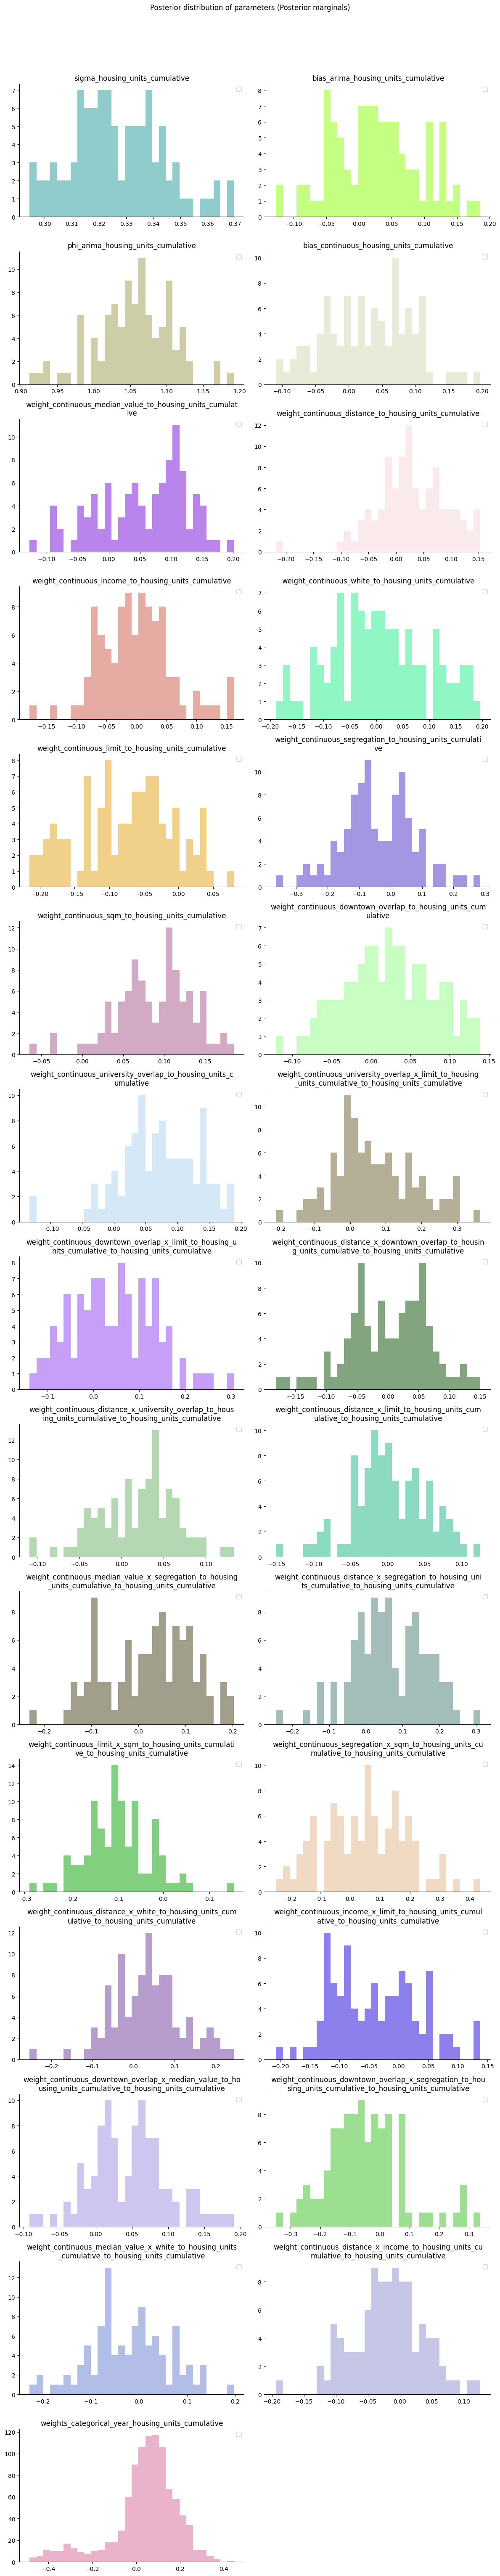

In [4]:
factual_samples = predictor.predictive(data = predictor.nonified_data) 

specific_names = ['sigma_housing_units_cumulative', 'bias_arima_housing_units_cumulative', 'phi_arima_housing_units_cumulative', 'bias_continuous_housing_units_cumulative']
weigth_names = [name for name in factual_samples.keys() if name.startswith("weight")]
param_sites = specific_names + weigth_names

assert all(name in factual_samples.keys() for name in param_sites)

plot_coefs(factual_samples, param_sites, true_params=None, title="Posterior marginals")

In [5]:
factual_intervention = {"radius_blue": 106.7, "limit_blue": 0, "radius_yellow_line": 402.3, "radius_yellow_stop": 804.7, "limit_yellow": 0.5, "reform_year": 2015}
extreme_intervention = {"radius_blue": 1450, "limit_blue": 0, "radius_yellow_line": 2640, "radius_yellow_stop": 2640, "limit_yellow": 0.3, "reform_year": 2012}


with db_connection() as conn:
    predictor = TractsModelPredictor(conn)
    factual_intervention = predictor._tracts_intervention(conn, **factual_intervention)
    extreme_intervention = predictor._tracts_intervention(conn, **extreme_intervention)


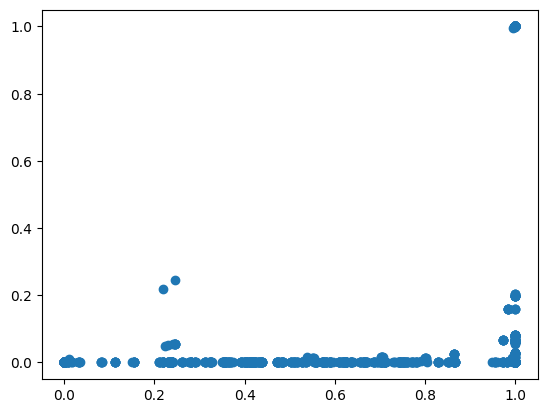

In [6]:
actual_limit = predictor.nonified_data['continuous']['mean_limit_original']


#plt.scatter(actual_limit, factual_intervention)

plt.scatter(actual_limit, extreme_intervention)

dict_keys(['sigma_housing_units_cumulative', 'bias_arima_housing_units_cumulative', 'phi_arima_housing_units_cumulative', 'bias_continuous_housing_units_cumulative', 'weight_continuous_median_value_to_housing_units_cumulative', 'weight_continuous_distance_to_housing_units_cumulative', 'weight_continuous_income_to_housing_units_cumulative', 'weight_continuous_white_to_housing_units_cumulative', 'weight_continuous_limit_to_housing_units_cumulative', 'weight_continuous_segregation_to_housing_units_cumulative', 'weight_continuous_sqm_to_housing_units_cumulative', 'weight_continuous_downtown_overlap_to_housing_units_cumulative', 'weight_continuous_university_overlap_to_housing_units_cumulative', 'weight_continuous_university_overlap_x_limit_to_housing_units_cumulative_to_housing_units_cumulative', 'weight_continuous_downtown_overlap_x_limit_to_housing_units_cumulative_to_housing_units_cumulative', 'weight_continuous_distance_x_downtown_overlap_to_housing_units_cumulative_to_housing_units_cu

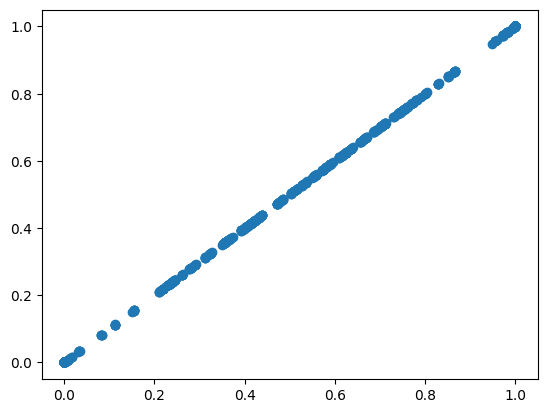

In [7]:
predictor.clear_reshaped_model_data()
samples =  predictor.predictive(predictor.nonified_data, 
                                force_ts_reshape = False)

sample_limit = samples['limit'][1,0,:]
actual_limit.shape

assert torch.all(samples['limit'][1,0,:] == samples['limit'][0,0,:])
assert torch.all(samples['limit'][1,0,:] == actual_limit)
#assert sample_limit.shape == actual_limit.shape

print(
samples.keys()
)
plt.scatter(actual_limit, sample_limit)

In [20]:
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual


predictor.clear_reshaped_model_data()
with MultiWorldCounterfactual() as mwc:
    with do(actions = {"limit": (factual_intervention, extreme_intervention)}):
        samples =  predictor.predictive(predictor.nonified_data, 
                                        )

limit = samples['limit']
outcome = samples['predicted_housing_units_cumulative']

#.view(..., predictor.data['n_series'], predictor.data['T'])

print("limit", limit.shape)
print("raw outcome", outcome.shape)    


with mwc:
    factual_limit = gather(limit, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(limit, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(limit, IndexSet(**{"limit": {2}}), event_dims=0)

    # note this is needed o/w indices are wrong!
    outcome = outcome.squeeze(-1)
    print(limit.shape)
    print(outcome.shape)
    print(indices_of(outcome))
    factual_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0).squeeze().view(predictor.num_samples,predictor.data['n_series'],predictor.data['T'])


limit torch.Size([100, 1, 3, 1, 1, 1, 1130])
raw outcome torch.Size([100, 1, 1, 3, 10, 1, 1, 113, 1])
torch.Size([100, 1, 3, 1, 1, 1, 1130])
torch.Size([100, 1, 1, 3, 10, 1, 1, 113])
IndexSet({'limit': {0, 1, 2}})


tensor(404.6760) tensor(154.0319)
torch.Size([113, 10])
observed torch.Size([113, 10])
torch.Size([100, 113, 10])


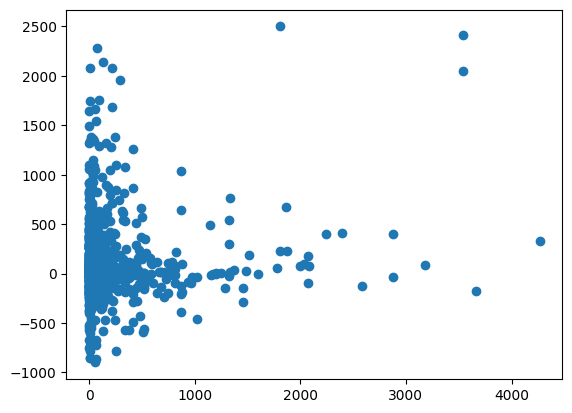

In [23]:
# print(predictor.data.keys())

print(predictor.data['housing_units_cumulative_std'],
       predictor.data['housing_units_cumulative_mean'])

print(predictor.data['reshaped']["continuous"]["housing_units_cumulative_original"].shape)

def destandardize_housing_units_cumulative(value):
    return value * predictor.data['housing_units_cumulative_std'] + predictor.data['housing_units_cumulative_mean']


observed_units = predictor.data['reshaped']["continuous"]["housing_units_cumulative_original"]
print("observed", observed_units.shape)

print(factual_units.shape)

factual_units_destandardized = destandardize_housing_units_cumulative(factual_units).squeeze()
low_units_destandardized = destandardize_housing_units_cumulative(low_units).squeeze()
high_units_destandardized = destandardize_housing_units_cumulative(high_units).squeeze()


plt.scatter(observed_units.flatten(), factual_units_destandardized.mean(dim = 0), label = "factual")
plt.show()



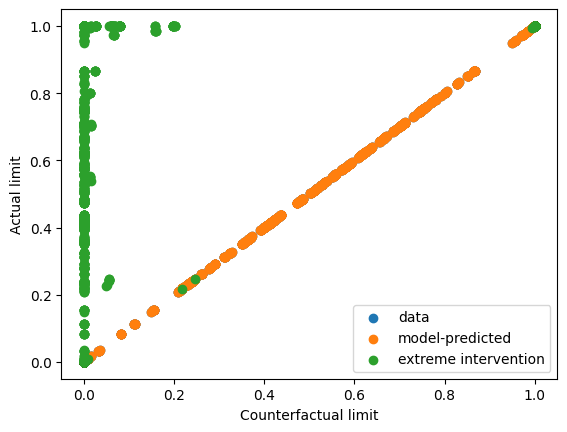

In [41]:
plt.scatter(observed_limit.mean(dim = 0).squeeze(), actual_limit, label = "data")
plt.scatter(low_limit.mean(dim = 0).squeeze(), actual_limit, label = "model-predicted")
plt.scatter(high_limit.mean(dim = 0).squeeze(), actual_limit, label = "extreme intervention")
plt.xlabel("Counterfactual limit")
plt.ylabel("Actual limit")
plt.legend()
plt.show()

# this is as expected

In [50]:
actual_cumulative = predictor.data['continuous']['housing_units_cumulative_original']


# plt.scatter(observed_limit.mean(dim = 0).squeeze(), actual_limit, label = "data")
# plt.scatter(low_limit.mean(dim = 0).squeeze(), actual_limit, label = "model-predicted")
# plt.scatter(high_limit.mean(dim = 0).squeeze(), actual_limit, label = "extreme intervention")
# plt.xlabel("Counterfactual limit")
# plt.ylabel("Actual limit")
# plt.legend()
# plt.show()


In [16]:

y_true = predictor.data['reshaped']['continuous']['housing_units_cumulative_original']


factual_samples['destandardized_housing_units_cumulative'] = (factual_samples['predicted_housing_units_cumulative'] *
                                                predictor.data['housing_units_cumulative_std'] +
                                                predictor.data['housing_units_cumulative_mean'])

factual_samples['bias_arima_housing_units_cumulative'].shape

# summary_destandardized = summarize_time_series(samples,
#                                 y_true, y_site="destandardized_housing_units_cumulative",
#                                 clamp_at_zero=True)

# plot_model_summary(summary_destandardized, y_true_original, 
#                    title="Posterior predictive check (denstandardized)",
#                    path = "ts_model_summary_cumulative.png")

# factual_samples['city_housing_units_observed'] = y_true.sum(dim=-2)
# factual_samples['city_housing_units_predicted'] = factual_samples['destandardized_housing_units_cumulative'].sum(dim=-2)


# samples.keys()

# samples['city_housing_units_observed'] = y_true_original.sum(dim=-2)
# samples['city_housing_units_predicted'] = samples['destandardized_housing_units_cumulative'].sum(dim=-2)

# summary_citywide = summarize_time_series(samples, samples['city_housing_units_observed'], y_site='city_housing_units_predicted')



# plot_model_summary(summary_citywide, samples['city_housing_units_observed'], title="Citywide cumulative housing units prediction", path = "citywide_housing_units_cumulative.png")

# factual_samples['limit'].shape
#summary = summarize_time_series(samples, y_true, y_site="predicted_housing_units_cumulative")
#plot_model_summary(summary, y_true, waic=waic, title="posterior predictive check", 
#                   path = "cumulative model evaluation.png")

torch.Size([100, 1, 1])